In [3]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import metpy.calc as mpcalc
import xarray as xr
from metpy.plots import USCOUNTIES

# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)
def calculate_dewpoint(temperature, relative_humidity):
    """
    Calculate dew point temperature using the Magnus-Tetens formula.

    Args:
        temperature (float or numpy.ndarray): Temperature in Kelvin.
        relative_humidity (float or numpy.ndarray): Relative humidity as a percentage (0 to 100).

    Returns:
        float or numpy.ndarray: Dew point temperature in Kelvin.
    """
    a = 17.27
    b = 237.7
    # Convert relative humidity from percentage to fraction
    relative_humidity = relative_humidity / 100.0
    alpha = ((a * temperature) / (b + temperature)) + np.log(relative_humidity)
    dewpoint = (b * alpha) / (a - alpha)
    return dewpoint

def calculate_theta_e(temperature, pressure, relative_humidity):
    """
    Calculate equivalent potential temperature (theta-e) using temperature, pressure,
    and relative humidity.

    Args:
        temperature (float or numpy.ndarray): Temperature in Kelvin.
        pressure (float or numpy.ndarray): Pressure in hPa (hectopascals).
        relative_humidity (float or numpy.ndarray): Relative humidity as a percentage (0 to 100).

    Returns:
        float or numpy.ndarray: Equivalent potential temperature (theta-e) in Kelvin.
    """
    # Convert relative humidity from percentage to fraction
    relative_humidity = relative_humidity / 100.0

    # Calculate dew point temperature
    dewpoint = calculate_dewpoint(temperature, relative_humidity)

    # Calculate virtual temperature
    virtual_temperature = temperature * (1 + 0.61 * relative_humidity)

    # Calculate the ratio of potential temperatures
    theta_ratio = 373.15 / (dewpoint + 273.15)  # 373.15 K is the reference temperature

    # Calculate the equivalent potential temperature (theta-e)
    theta_e = virtual_temperature * theta_ratio ** 0.2854

    return theta_e

def calc_thetae(temperature, pressure, mixing_ratio):
    theta = temperature * (1000.0 / pressure) ** 0.286 + 3 * mixing_ratio
    return theta

def plot_data(data, time):
    istep = 0
    level = 850000
    h1000 = 1000
    h900 = 900
    h850 = 850
    h700 = 700
    time_dim_name = list(uvar.dims)[0]

    tempk_h1000 = uvar.sel(isobaric=1000*100, method='nearest').isel(**{time_dim_name: istep}).data
    temp_h1000 = tempk_h1000 
    temp_h1000 = units.Quantity(temp_h1000, 'K')
    rh_h1000 = ref.sel(isobaric=1000*100, method='nearest').isel(**{time_dim_name: istep}).data
    td_h1000 = mpcalc.dewpoint_from_relative_humidity(temp_h1000, rh_h1000)
    uwnd_h1000 = uwnd.sel(isobaric=1000*100, method='nearest').isel(**{time_dim_name: istep}).data
    vwnd_h1000 = vwnd.sel(isobaric=1000*100, method='nearest').isel(**{time_dim_name: istep}).data


    tempk_h850 = uvar.sel(isobaric=h850*100, method='nearest').isel(**{time_dim_name: istep}).data
    temp_h850 = tempk_h850 
    temp_h850 = units.Quantity(temp_h850, 'K')
    rh_h850 = ref.sel(isobaric=h850*100, method='nearest').isel(**{time_dim_name: istep}).data
    td_h850 = mpcalc.dewpoint_from_relative_humidity(temp_h850, rh_h850)

    tempk_h700 = uvar.sel(isobaric=h700*100, method='nearest').isel(**{time_dim_name: istep}).data
    temp_h700 = tempk_h700 
    temp_h700 = units.Quantity(temp_h700, 'K')
    rh_h700 = ref.sel(isobaric=h700*100, method='nearest').isel(**{time_dim_name: istep}).data
    td_h700 = mpcalc.dewpoint_from_relative_humidity(temp_h700, rh_h700)

    mixingratio_h1000 = mpcalc.mixing_ratio_from_relative_humidity(h1000*units.hPa, (tempk_h1000 - 273.15) * units.degC, rh_h1000 / 100).to('g/kg')
    mixingratio_h850 = mpcalc.mixing_ratio_from_relative_humidity(h850*units.hPa, (tempk_h850 - 273.15) * units.degC, rh_h850 / 100).to('g/kg')
    mixingratio_h700 = mpcalc.mixing_ratio_from_relative_humidity(h700*units.hPa, (tempk_h700 - 273.15) * units.degC, rh_h700 / 100).to('g/kg')
    #print(mixingratio_h1000)

    new_thetah1000 = calc_thetae(tempk_h1000, h1000, mixingratio_h1000.magnitude)
    new_thetah850 = calc_thetae(tempk_h850, h850, mixingratio_h850.magnitude)
    new_thetah700 = calc_thetae(tempk_h700, h1000, mixingratio_h700.magnitude)
    
    thetae_h1000 = calculate_theta_e(tempk_h1000, h1000*100, rh_h1000)
    thetae_h850 = calculate_theta_e(tempk_h850, h850*100, rh_h850)
    thetae_h700 = calculate_theta_e(tempk_h700, h700*100, rh_h700)

    lon = np.linspace(-92, -80, tempk_h850.shape[1])
    lat = np.linspace(40, 49, tempk_h850.shape[0])

    thetae_h1000_da = xr.DataArray(thetae_h1000, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
    thetae_h850_da = xr.DataArray(thetae_h850, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
    thetae_h700_da = xr.DataArray(thetae_h700, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
    new_thetae_h1000_da = xr.DataArray(new_thetah1000, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
    new_thetae_h850_da = xr.DataArray(new_thetah850, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
    new_thetae_h700_da = xr.DataArray(new_thetah700, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})

    new_theta_lapserate_1500 = (new_thetah850 - new_thetah1000) / 1.5
    new_theta_lapserate_3000 = (new_thetah700 - new_thetah1000) / 3

    lapse_rate_1500 = (tempk_h850 - tempk_h1000) / 1.5
    lapse_rate_3000 = (tempk_h700 - tempk_h1000) / 3.0

    div = mpcalc.divergence(uwnd_h1000 * units('m/s'), vwnd_h1000* units('m/s'), dx = 13e3*units.meters, dy=13e3*units.meters) * -1e5

    lon = np.linspace(-92, -80, tempk_h850.shape[1])
    lat = np.linspace(40, 49, tempk_h850.shape[0])
    orig_map=plt.cm.get_cmap('Reds')
  
    reversed_map = orig_map.reversed()

    lon0 = grid.longitude_of_central_meridian
    lat0 = grid.latitude_of_projection_origin
    lat1 = grid.standard_parallel
    earth_radius = grid.earth_radius

    globe = ccrs.Globe(ellipse='sphere', semimajor_axis=grid.earth_radius)
    datacrs = ccrs.PlateCarree() 
    crs = ccrs.LambertConformal(central_longitude=lon0, central_latitude=lat0, standard_parallels=(lat0, lat1), globe=globe)
    
    fig = plt.figure(figsize=(18, 12)) 
    ax = fig.add_subplot(1, 1, 1, projection=crs) 
    
    ax.set_extent([-90.5, -84.0, 45.5, 48], datacrs) 

    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=2)
    ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha = 0.5)

    cf = ax.contourf(thetae_h850_da.metpy.x, thetae_h850_da.metpy.y, ndimage.gaussian_filter(div, sigma=3, order=0), transform=ccrs.PlateCarree(), cmap='jet')
    plt.colorbar(cf, orientation='horizontal', extend=max, aspect=65, pad=0, extendrect='True', label = 'Divergence (1x10^-5) s^-1')

    #c = ax.contour(thetae_h850_da.metpy.x, thetae_h850_da.metpy.y, ndimage.gaussian_filter(lapse_rate_1500, sigma=3, order=0), levels=range(-11, 1, 1), colors='black', transform=datacrs)
    #ax.clabel(c, fontsize=12, inline=1, inline_spacing=4, fmt='%i')

    plt.title('RAP Surface Divergence')
    plt.title('VALID: {:s}z'.format(str(time)), loc='right')
    plt.show()
    plt.close()

https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.html?dataset=rap130/202305/20230501/rap_130_20230501_0300_000.grb2


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.html?dataset=rap130/202305/20230501/rap_130_20230501_0300_000.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.xml?dataset=rap130/202305/20230501/rap_130_20230501_0300_000.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


{'Pressure_zeroDegC_isotherm', 'Planetary_Boundary_Layer_Height_surface', 'V-Component_Storm_Motion_height_above_ground_layer', 'v-component_of_wind_tropopause', 'Layer_Thickness_isotherm_layer', 'Geopotential_height_convective_cloud_top', 'Precipitable_water_entire_atmosphere_single_layer', 'u-component_of_wind_pressure_difference_layer', 'Categorical_Rain_surface', 'Enhanced_Stretching_Potential_height_above_ground_layer', 'Lightning_surface', 'Relative_Humidity_with_Respect_to_Precipitable_Water_entire_atmosphere', 'Geopotential_height_cloud_tops', 'Categorical_Ice_Pellets_surface', 'u-component_of_wind_isobaric', 'Reflectivity_height_above_ground', 'Relative_humidity_isobaric', 'Haines_index_surface', 'Vertical_velocity_pressure_pressure_difference_layer', 'Pressure_height_above_ground', 'v-component_of_wind_height_above_ground', 'Mass_density_concentration_height_above_ground', 'Relative_humidity_zeroDegC_isotherm', 'v-component_of_wind_pressure_difference_layer', 'Dewpoint_depres

C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


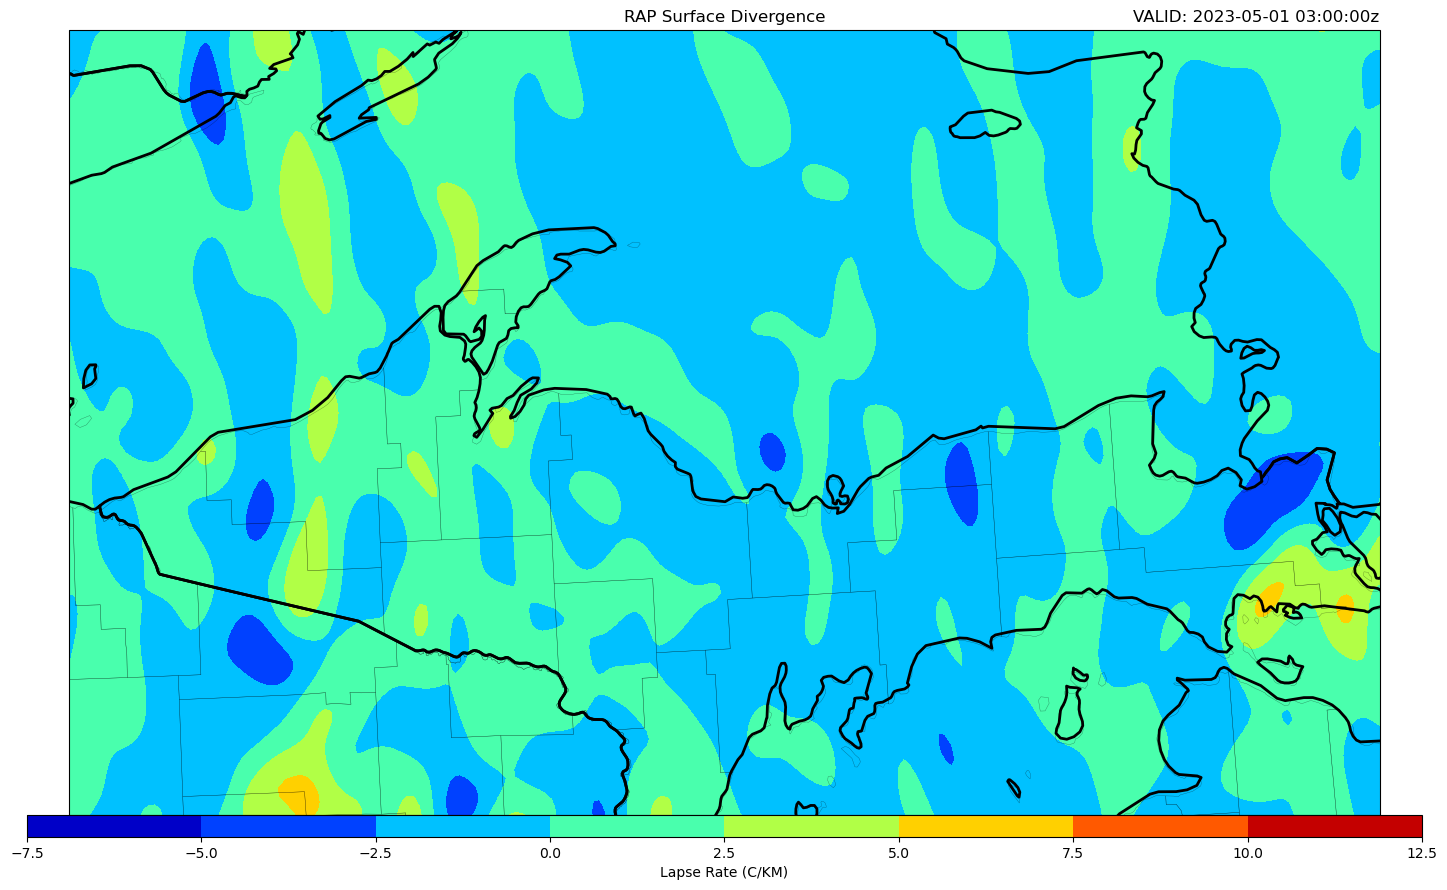

https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.html?dataset=rap130/202305/20230501/rap_130_20230501_0300_001.grb2


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.html?dataset=rap130/202305/20230501/rap_130_20230501_0300_001.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.xml?dataset=rap130/202305/20230501/rap_130_20230501_0300_001.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


{'Pressure_zeroDegC_isotherm', 'Planetary_Boundary_Layer_Height_surface', 'V-Component_Storm_Motion_height_above_ground_layer', 'v-component_of_wind_tropopause', 'Layer_Thickness_isotherm_layer', 'Geopotential_height_convective_cloud_top', 'Precipitable_water_entire_atmosphere_single_layer', 'u-component_of_wind_pressure_difference_layer', 'Categorical_Rain_surface', 'Enhanced_Stretching_Potential_height_above_ground_layer', 'Lightning_surface', 'Relative_Humidity_with_Respect_to_Precipitable_Water_entire_atmosphere', 'Geopotential_height_cloud_tops', 'Categorical_Ice_Pellets_surface', 'Water_equivalent_of_accumulated_snow_depth_surface_1_Hour_Accumulation', 'u-component_of_wind_isobaric', 'Reflectivity_height_above_ground', 'Relative_humidity_isobaric', 'Haines_index_surface', 'Vertical_velocity_pressure_pressure_difference_layer', 'Pressure_height_above_ground', 'v-component_of_wind_height_above_ground', 'Mass_density_concentration_height_above_ground', 'Relative_humidity_zeroDegC_is

C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


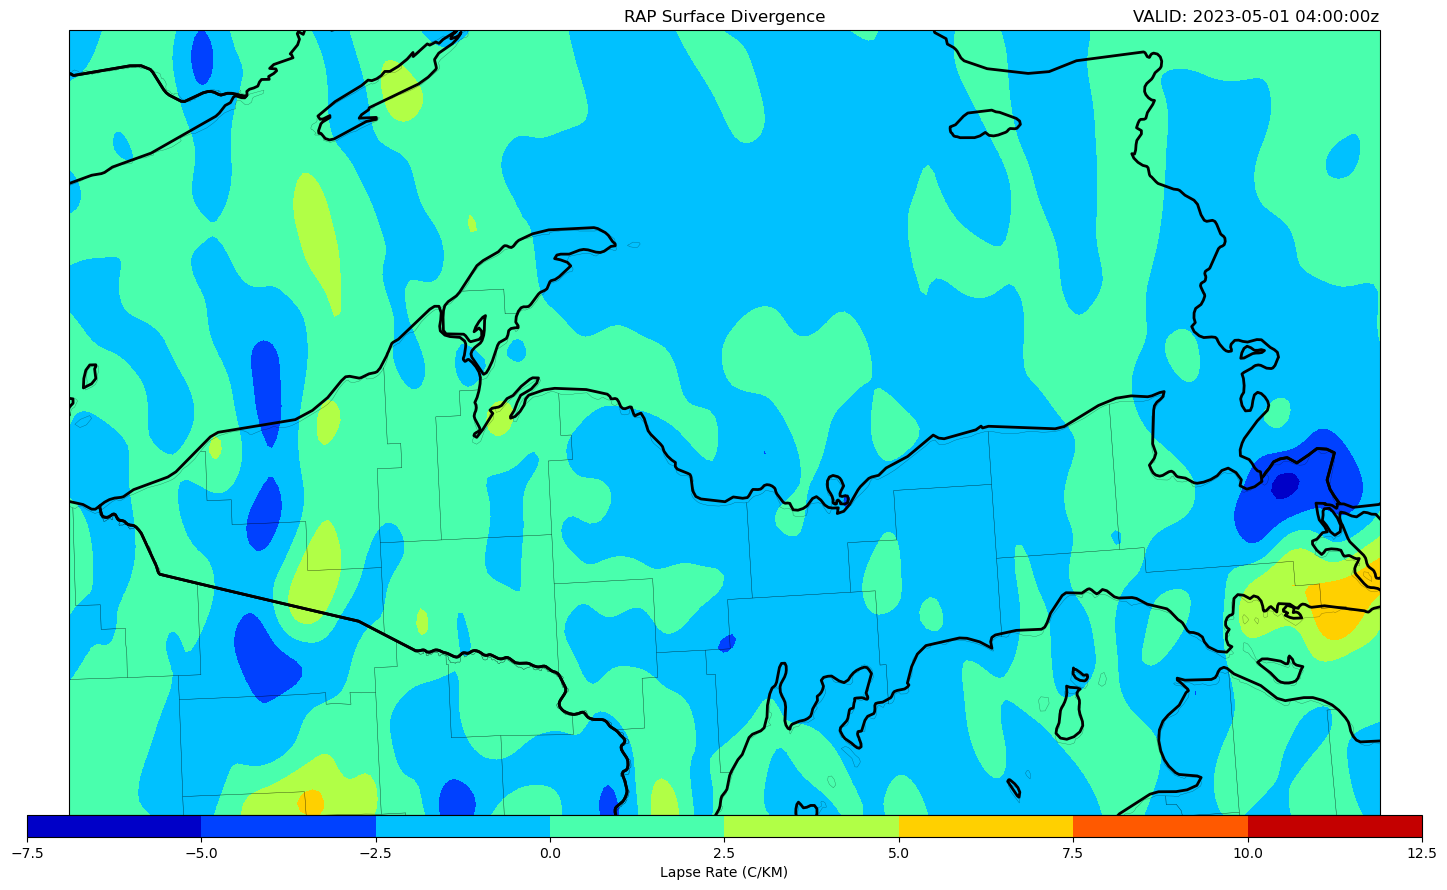

https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.html?dataset=rap130/202305/20230501/rap_130_20230501_0300_002.grb2


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.html?dataset=rap130/202305/20230501/rap_130_20230501_0300_002.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.xml?dataset=rap130/202305/20230501/rap_130_20230501_0300_002.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


{'Pressure_zeroDegC_isotherm', 'Planetary_Boundary_Layer_Height_surface', 'V-Component_Storm_Motion_height_above_ground_layer', 'v-component_of_wind_tropopause', 'Layer_Thickness_isotherm_layer', 'Geopotential_height_convective_cloud_top', 'Precipitable_water_entire_atmosphere_single_layer', 'u-component_of_wind_pressure_difference_layer', 'Categorical_Rain_surface', 'Enhanced_Stretching_Potential_height_above_ground_layer', 'Lightning_surface', 'Relative_Humidity_with_Respect_to_Precipitable_Water_entire_atmosphere', 'Geopotential_height_cloud_tops', 'Categorical_Ice_Pellets_surface', 'u-component_of_wind_isobaric', 'Reflectivity_height_above_ground', 'Relative_humidity_isobaric', 'Haines_index_surface', 'Vertical_velocity_pressure_pressure_difference_layer', 'Pressure_height_above_ground', 'v-component_of_wind_height_above_ground', 'Mass_density_concentration_height_above_ground', 'Relative_humidity_zeroDegC_isotherm', 'Convective_precipitation_surface_Mixed_intervals_Accumulation', 

C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


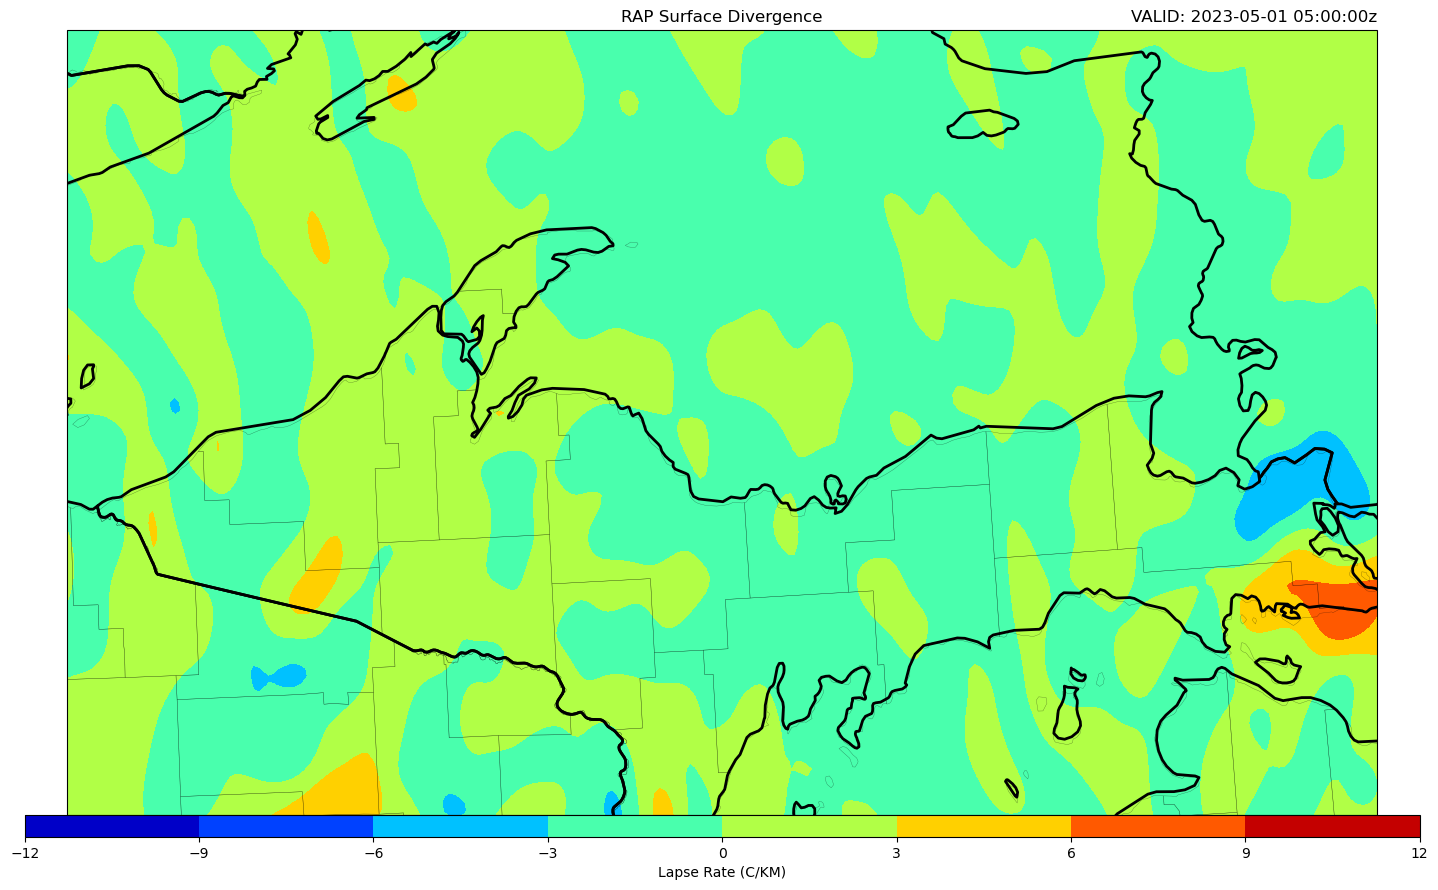

In [4]:
catalog_url_base = 'https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.html'
forecast_hours = [str(i).zfill(3) for i in range(0, 3, 1)]  # Forecast hours 0, 3, 6, ..., 51

for forecast_hour in forecast_hours:
    catalog_url = f'{catalog_url_base}?dataset=rap130/202305/20230501/rap_130_20230501_0300_{forecast_hour}.grb2'
    print(catalog_url)
    cat = TDSCatalog(catalog_url)
    ncss = cat.datasets[0].subset()
    print(ncss.variables)
    query = ncss.query()
    query.lonlat_box(north=65, south=15, east=310, west=220)
    query.accept('netcdf')

    query.variables('Temperature_isobaric', 'Relative_humidity_isobaric', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')

    data = ncss.get_data(query)

    temp_var = data.variables['Temperature_isobaric']
    rh_var = data.variables['Relative_humidity_isobaric']
    u_wind_var850 = data.variables['u-component_of_wind_isobaric'][:] * units('m/s')
    v_wind_var850 = data.variables['v-component_of_wind_isobaric'][:] * units('m/s')
    time_var = data.variables[find_time_var(rh_var)]

    temp = temp_var[:].squeeze()
    rh_var = rh_var[:].squeeze()
    u_wind850 = u_wind_var850[:].squeeze()
    v_wind850 = v_wind_var850[:].squeeze()

    temp = units.Quantity(temp, 'kelvin')
    temp = temp.to('degC')

    u_wind850 = units.Quantity(u_wind850, 'm/s')
    v_wind850 = units.Quantity(v_wind850, 'm/s')

    wnd = mpcalc.wind_speed(u_wind850, v_wind850)
    wnd = wnd.to('kt')

    time = num2date(time_var[:].squeeze(), time_var.units)
    rh = ndimage.gaussian_filter(rh_var, sigma=2, order=0)
    nc = xr.open_dataset(xr.backends.NetCDF4DataStore(data)).metpy.parse_cf()
    uvar_name = 'Temperature_isobaric'
    uvar = nc[uvar_name]
    ref_name = 'Relative_humidity_isobaric'
    ref = nc[ref_name]
    grid = nc[uvar.grid_mapping]
    uwnd = nc['u-component_of_wind_isobaric']
    vwnd = nc['v-component_of_wind_isobaric']
    plot_data(data, time)